In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('icefire')

In [12]:
## Load sample orderbook data
df = pd.read_csv('../../../Datasets/snapshot_25_by_day/bybit_book_snapshot_25_2023-10-14_SOLUSDT.csv.gz')

In [13]:
for c in df.select_dtypes(include = 'object').columns:
    if df[c].nunique() == 1:
        df.drop(columns = [c], inplace = True)
        
df.head()

,timestamp,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1697241598758000,1697241600177951,21.824,729.2,21.823,764.4,21.825,234.5,21.822,358.5,...,21.801,2755.0,21.847,628.1,21.8,2374.0,21.848,1247.8,21.799,1438.0
1,1697241598777000,1697241600177977,21.824,729.2,21.823,764.4,21.825,355.8,21.822,358.5,...,21.801,2755.0,21.847,628.1,21.8,2374.0,21.848,1247.8,21.799,1438.0
2,1697241598877000,1697241600178006,21.824,729.2,21.823,764.4,21.825,355.8,21.822,358.5,...,21.801,1378.9,21.847,628.1,21.8,2374.0,21.848,1247.8,21.799,1438.0
3,1697241598898000,1697241600178011,21.824,729.2,21.823,764.4,21.825,355.8,21.822,358.5,...,21.801,2755.0,21.847,628.1,21.8,2374.0,21.848,1247.8,21.799,1438.0
4,1697241598997000,1697241600178017,21.824,729.2,21.823,764.4,21.825,355.8,21.822,358.5,...,21.801,2755.0,21.847,628.1,21.8,2374.0,21.848,1247.8,21.799,1438.0


In [14]:
cols = [c for c in df.columns if c not in ['timestamp', 'local_timestamp']]
d = pd.DataFrame(df[cols].loc[3] == df[cols].loc[4])
d[d[0] == False]

,0
asks[22].amount,False


In [15]:
%%capture
df[[c for c in df.columns if ('bid' in c)]].loc[0]

In [16]:
# For now, I will aggregate on timestamp. I guess, it is UTC time in microseconds
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')

In [17]:
%%time
t = '15T'        # 1 minutes
agg_df = pd.DataFrame()
for level in range(0, 25):
    for side in ['asks', 'bids']:
        
        '''
            List of features for both buy and sell sides:
            - min, max, std, mean, median, first, last
            - weighted average price on volume
            - price spread, volume range
            - skewness and kurtosis (to investigate the affect of outliers in the order placement)
            - Trade imbalance: bid volume / ask volume
            
            Notes: 
            1. We may create a few indicators derived from the above features including RSI, CCI, etc... 
            2. First and last are meaningless in the context, unless we want to learn price and volume at the beginning and end of the time interval
                - When I used open and close price of OHLCV in the classification models, the performance was slightly worse.
        '''
   
        price_col, vol_col = f'{side}[{level}].price', f'{side}[{level}].amount'

        df['wt_avg_price'] = (df[vol_col] * df[price_col])

        # Grouper
        g           = df.resample(t, on = 'timestamp')
        price_g     = g[price_col]
        volume_g    = g[vol_col]
        wt_g        = g['wt_avg_price']

        # Price related aggregation
        d = price_g.agg(['first', 'min', 'max', 'last', 'std', 'mean', 'median'])
        d['wt_avg_price']   = wt_g.sum() / volume_g.sum()
        d['spread']         = d['max'] - d['min']
        d['skewness']       = price_g.skew()
        d['kurtosis']       = price_g.apply(pd.Series.kurt)
        d.rename(columns = {f : f'{price_col}_{f}' for f in d.columns}, inplace = True)

        v = volume_g.agg(['first', 'min', 'max', 'last', 'std', 'mean', 'median', 'count'])
        v['vol_range']      = v['max'] - v['min']
        v['skewness']       = volume_g.skew()
        v['kurtosis']       = volume_g.apply(pd.Series.kurt)
        v.rename(columns = {f : f'{vol_col}_{f}' for f in v.columns}, inplace = True)

        # combine
        comb = d.join(v)        # joins on datetime index
        comb.reset_index(inplace = True, drop = False)

        # add the combined features into master agg dataframe
        agg_df = comb if agg_df.empty else agg_df.merge(comb, on = 'timestamp')
    
    # Trade imbalance    
    agg_df[f'imb[{level}]'] = (agg_df[f'bids[{level}].amount_mean'] * agg_df[f'bids[{level}].amount_count']) / (agg_df[f'asks[{level}].amount_mean'] * agg_df[f'asks[{level}].amount_count'])

print(agg_df.shape)

(97, 1126)
CPU times: user 17.1 s, sys: 27.7 s, total: 44.7 s
Wall time: 57.8 s


In [18]:
# handling missing values
agg_df = agg_df.fillna(method = 'bfill').fillna(method = 'ffill')

In [19]:
cols = ['timestamp'] + [c for c in agg_df.columns if ('amount' in c) & ('max' in c) & ('0' in c)]
cols = ['timestamp'] + [c for c in agg_df.columns if ('wt_avg_price' in c)]
agg_df[cols].tail(10)

,timestamp,asks[0].price_wt_avg_price,bids[0].price_wt_avg_price,asks[1].price_wt_avg_price,bids[1].price_wt_avg_price,asks[2].price_wt_avg_price,bids[2].price_wt_avg_price,asks[3].price_wt_avg_price,bids[3].price_wt_avg_price,asks[4].price_wt_avg_price,...,asks[20].price_wt_avg_price,bids[20].price_wt_avg_price,asks[21].price_wt_avg_price,bids[21].price_wt_avg_price,asks[22].price_wt_avg_price,bids[22].price_wt_avg_price,asks[23].price_wt_avg_price,bids[23].price_wt_avg_price,asks[24].price_wt_avg_price,bids[24].price_wt_avg_price
87,2023-10-14 21:30:00,21.932292,21.935781,21.933054,21.931781,21.934823,21.930762,21.935807,21.930155,21.936259,...,21.952856,21.915452,21.955292,21.913874,21.957590,21.914112,21.957863,21.913366,21.958809,21.912741
88,2023-10-14 21:45:00,21.937572,21.937969,21.937629,21.935573,21.939361,21.935388,21.940771,21.932583,21.939853,...,21.958830,21.916701,21.958217,21.916043,21.961183,21.915021,21.963073,21.912196,21.963049,21.911126
89,2023-10-14 22:00:00,21.956172,21.954979,21.954738,21.954990,21.955855,21.953259,21.956268,21.953292,21.959701,...,21.976349,21.934068,21.977315,21.934113,21.978268,21.931884,21.978445,21.931649,21.981321,21.930291
90,2023-10-14 22:15:00,21.949084,21.949776,21.950876,21.948086,21.953212,21.948308,21.954819,21.949499,21.954285,...,21.972123,21.930631,21.971328,21.929270,21.975128,21.926320,21.975886,21.927719,21.978195,21.925937
91,2023-10-14 22:30:00,21.946724,21.942861,21.948680,21.942038,21.950157,21.942208,21.950514,21.942735,21.952492,...,21.966791,21.924930,21.967484,21.924603,21.971448,21.922740,21.970315,21.921963,21.971153,21.921791
92,2023-10-14 22:45:00,21.979639,21.979461,21.981817,21.977236,21.983424,21.978106,21.980193,21.976334,21.979945,...,22.001788,21.958757,21.999966,21.957445,22.001931,21.954989,22.001671,21.956424,22.002311,21.953436
93,2023-10-14 23:00:00,22.006823,22.004666,22.007451,22.003831,22.007556,22.002492,22.008977,22.001018,22.010173,...,22.026675,21.985103,22.027071,21.984205,22.028049,21.982807,22.029685,21.982214,22.029725,21.981759
94,2023-10-14 23:15:00,22.004740,22.000234,22.004058,21.998713,22.005914,21.998338,22.007464,21.996863,22.007507,...,22.022504,21.981594,22.024194,21.980736,22.024247,21.979225,22.025000,21.978748,22.026268,21.977320
95,2023-10-14 23:30:00,21.989805,21.990722,21.988654,21.988812,21.991668,21.991006,21.991925,21.985912,21.994685,...,22.010919,21.968977,22.012192,21.969212,22.013450,21.967281,22.013530,21.965805,22.015473,21.964254
96,2023-10-14 23:45:00,21.989671,21.988836,21.990954,21.990016,21.992259,21.986727,21.991641,21.985120,21.993694,...,22.009848,21.968492,22.010498,21.967929,22.011295,21.967011,22.012235,21.965638,22.012578,21.964728


In [20]:
diff_df = pd.DataFrame()
diff_df['timestamp'] = agg_df['timestamp']
for i in range(0, 25):
    diff_df[f'diff_{i}'] = agg_df[f'asks[{i}].price_wt_avg_price'] - agg_df[f'bids[{i}].price_wt_avg_price']
    
diff_df.head()

,timestamp,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,...,diff_15,diff_16,diff_17,diff_18,diff_19,diff_20,diff_21,diff_22,diff_23,diff_24
0,2023-10-13 23:45:00,0.001000,0.003000,0.005000,0.007000,0.009000,0.011000,0.013000,0.015000,0.017000,...,0.031000,0.033000,0.035000,0.037000,0.039000,0.041000,0.043000,0.045000,0.047000,0.049000
1,2023-10-14 00:00:00,-0.003338,0.007885,0.003753,0.005688,0.007068,0.010670,0.011782,0.014305,0.017411,...,0.032272,0.032517,0.035123,0.036193,0.039993,0.040107,0.043176,0.046021,0.049886,0.047176
2,2023-10-14 00:15:00,0.002272,0.001060,0.004285,0.008448,0.010534,0.012173,0.016365,0.017017,0.016107,...,0.031819,0.031290,0.034514,0.039472,0.038818,0.041674,0.042465,0.045928,0.046092,0.048735
3,2023-10-14 00:30:00,-0.001648,-0.000122,0.003335,0.007603,0.006836,0.009982,0.011337,0.013658,0.015183,...,0.031275,0.032673,0.036502,0.038290,0.039845,0.043793,0.044851,0.046145,0.048188,0.048645
4,2023-10-14 00:45:00,0.000309,0.003946,0.005100,0.006829,0.008909,0.010967,0.012764,0.014872,0.017889,...,0.031269,0.033546,0.034570,0.037515,0.039022,0.041031,0.043584,0.045205,0.046103,0.048417


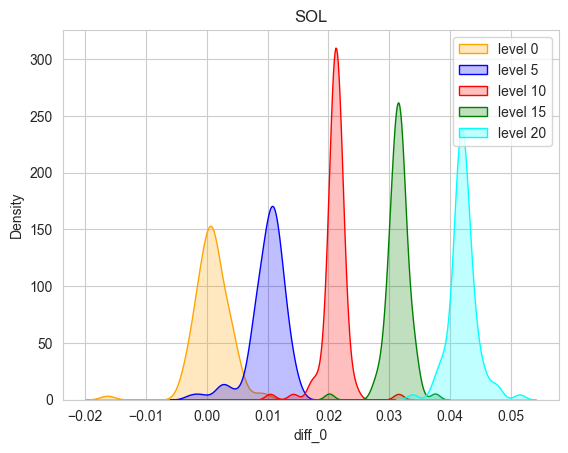

In [21]:
colors = ['orange', 'blue', 'red', 'green', 'cyan', 'pink']
for idx, i in enumerate(range(0, 25, 5)):
    sns.kdeplot(data = diff_df, x = f'diff_{i}', color = colors[idx], 
                label = f'level {i}', alpha = 0.25, fill = colors[idx])
plt.title('SOL')
plt.legend()
plt.show()

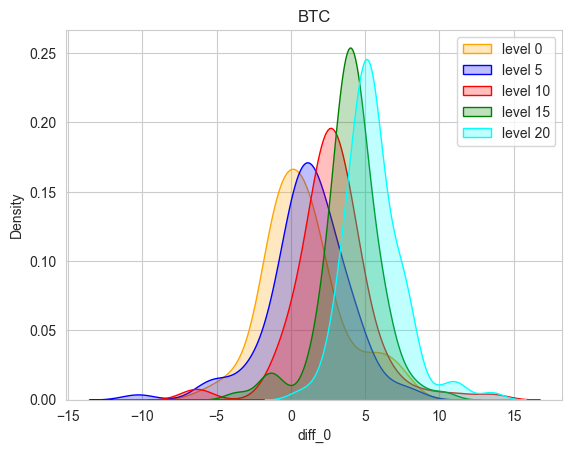

In [17]:
colors = ['orange', 'blue', 'red', 'green', 'cyan', 'pink']
for idx, i in enumerate(range(0, 25, 5)):
    sns.kdeplot(data = diff_df, x = f'diff_{i}', color = colors[idx], 
                label = f'level {i}', alpha = 0.25, fill = colors[idx])
plt.title('BTC')
plt.legend()
plt.show()

In [12]:
level = 0
agg_df[f'bids[{level}].amount_count'].describe().round()

count       97.0
mean     17771.0
std       4999.0
min          6.0
25%      14831.0
50%      17021.0
75%      20395.0
max      35827.0
Name: bids[0].amount_count, dtype: float64

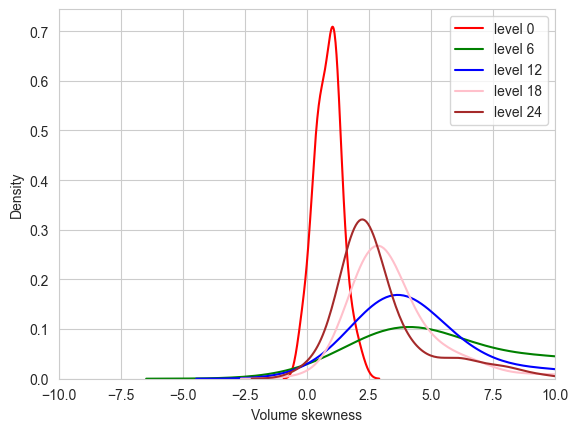

In [13]:
colors = ['red', 'green', 'blue', 'pink', 'brown', 'purple', 'cyan']
for idx, l in enumerate(range(0, 25, 6)):
    sns.kdeplot(data = agg_df, x = f'asks[{l}].amount_skewness', label = f'level {l}', color = colors[idx])
plt.legend()
plt.xlim([-10, 10])         # note that the original skewness values are between -40 and 45
plt.xlabel('Volume skewness')
plt.show()

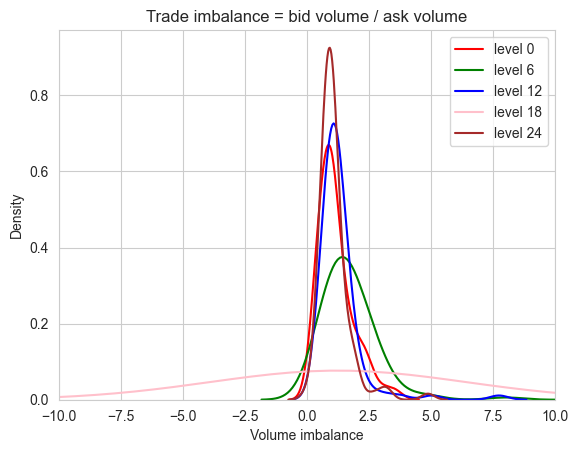

In [14]:
colors = ['red', 'green', 'blue', 'pink', 'brown', 'purple', 'cyan']
for idx, l in enumerate(range(0, 25, 6)):
    sns.kdeplot(data = agg_df, x = f'imb[{l}]', label = f'level {l}', color = colors[idx])
plt.legend()
plt.xlim([-10, 10])         # note that the imbalance is high as 100
plt.title('Trade imbalance = bid volume / ask volume')
plt.xlabel('Volume imbalance')
plt.show()

THINK: Hard to make sense of the above plots. There is no clear pattern because of shift in orders between the levels?
Keep in mind that the original data is the udpated 25-level snapshot for every microsecond, provide if there exists some trade activity. Most often the levels may not move much.